# <center>Assignment 3</center>

This assignment is based on embeddings and CNNs. You can choose to code in Python2 or Python3. All the imports made in this notebook are as below; if these imports work, you are (mostly) set to complete the assignment. You will learn the following:
* Making use of embeddings in Tensorflow
* Coding CNNs in TF
* Intuitions behind working of CNN
* Intuitions behind embeddings

In [0]:
from __future__ import print_function,division
import random 
import tensorflow as tf
import numpy as np
import os
from numpy import dot
from numpy.linalg import norm

In [3]:
from google.colab import files
uploaded = files.upload()

Saving class_neg.txt to class_neg.txt
Saving class_pos.txt to class_pos.txt


## Quick Review questions

* If the input volume has dimensions 10 x 10 x 32 (Height x Width x Channels), how many weights will be there in a filter that considers an area of 5 x 5?

<b>Answer:</b> 800
* If input volume has dimensions 10 x 10 x 32 and after convolution we get an output volume of 8 x 8 x 64, how many filters were used? 

<b>Answer:</b> 64
* What is inverted-dropout? Why is it done? 

<b>Answer:</b> In dropout you try to make activations of some neurons zero with probablity. The inverted drop out technique is dividing your activations vector with keep probablity, this is done in order to ensure that the expected value of that activation vector remains the same. THis also ensures that you don't have to perform a scaling at test time.

## Sentiment Classification - dataset analysis

We will use movie review dataset taken from http://www.cs.cornell.edu/people/pabo/movie-review-data/. The exact dataset we will use is the Sentence-polarity dataset.

In [4]:
data = []
for file_,label in zip(["class_neg.txt","class_pos.txt"],[0,1]):
    lines = open(file_).readlines()
    lines = list(map(lambda x:x.strip().replace("-"," ").split(),lines))
    for line in lines:
        data.append([line,label])
    print("Number of reviews of {} = {}".format(file_[:-4],len(lines)))
    print("\tMax number of tokens in a sentence = {}".format(max(map(lambda x:len(x),lines))))
    print("\tMin number of tokens in a sentence = {}".format(min(map(lambda x:len(x),lines))))
random.Random(5).shuffle(data)

Number of reviews of class_neg = 5331
	Max number of tokens in a sentence = 56
	Min number of tokens in a sentence = 1
Number of reviews of class_pos = 5331
	Max number of tokens in a sentence = 59
	Min number of tokens in a sentence = 2


Observe that the lengths of sentences are different. In case, we need to vectorize the operations, we need all sentences to be of equal length. Therefore, we will pad all sentences to be of equal length and substitute the padded parts of sentence with zeros. 

In [5]:
# See some randomly sampled sentences
print(" ".join(data[random.randint(0,len(data))][0]))

. . . while each moment of this broken character study is rich in emotional texture , the journey doesn't really go anywhere .


We will work with the sentence as given and not remove any stop-words or punctuation marks. 

In [6]:
sents = map(lambda x:x[0],data) # all sentences
all_words = set()
for sent in sents:
    all_words |= set(sent)
all_words = sorted(list(all_words))
vocab = {all_words[i]:i for i in range(len(all_words))}
print("Number of words : ",len(vocab))
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):]
train_data = []
train_targets = []
test_data = []
test_targets = []
for list_all,list_data,list_target,label_list in zip([train,test],[train_data,test_data],[train_targets,test_targets],["train","test"]):
    for datum,label in list_all:
        list_data.append([vocab[w] for w in datum])
        list_target.append([label])
    print(label_list)
    print("\tNumber of positive examples : ",list_target.count([1]))
    print("\tNumber of negative examples : ",list_target.count([0]))

Number of words :  19757
train
	Number of positive examples :  4288
	Number of negative examples :  4241
test
	Number of positive examples :  1043
	Number of negative examples :  1090


In [7]:
print(train_targets)

[[1], [1], [1], [0], [0], [0], [1], [1], [1], [1], [1], [1], [0], [1], [1], [0], [1], [1], [0], [0], [1], [0], [1], [1], [1], [0], [0], [1], [0], [1], [1], [0], [1], [1], [0], [1], [0], [1], [0], [1], [0], [0], [1], [0], [1], [0], [1], [1], [1], [0], [0], [0], [1], [0], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [0], [1], [0], [0], [0], [0], [1], [1], [0], [0], [1], [1], [0], [0], [1], [0], [1], [0], [1], [0], [0], [0], [0], [1], [0], [1], [1], [0], [1], [1], [1], [1], [0], [0], [1], [1], [1], [0], [0], [1], [0], [0], [1], [0], [0], [1], [1], [0], [1], [1], [1], [0], [0], [1], [1], [1], [1], [0], [0], [0], [1], [1], [1], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [1], [1], [1], [1], [0], [0], [1], [0], [0], [1], [0], [1], [0], [0], [0], [1], [1], [1], [0], [0], [1], [0], [1], [1], [0], [1], [1], [0], [0], [0], [1], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [0], [0], [0], [1], [0], [1], [0], [0], [0], [1], [0], [1], [0], [1], [1], [0], [0], [1],

For implementation purposes, we will need an index for the padded word and we will use the index 19757.
Note: For a dataset of this <i>small</i> size, we will need to do K-Fold Cross-validation to evaluate the performance. However, we will work with this train-test split for the rest of this assignment. 

## Simple Classifier

<img src="https://web.cs.dal.ca/~sastry/cnn_simple.jpg"/>

The above image shows the architecture of the simple model that we will implement for text classification. We are interested in the following hyperparameters apart from the number of filters (which we will set to 1 for this problem):
* The span of the filter/the number of words considered for making the prediction.
* The size of the stride.
* The number of activations selected for feeding into softmax classifier.

Before continuing:

* Can you reason how the machine is classifying (in the above example)? The values of the activations are color-coded. Is this the only possible way the machine can work? 

    (Your answer might look like : ... filter is ... template matching ... )

<b>Answer</b>: The convolution process in the above mentioned example is helping the network to learn the correlation between the adjascent inputs (which are words). When the filter convolves over the embedding matrix of a sentence, a feature tesnor is generated (The brown color grid after convolution). It does have some activations which have high values and some activations having low values (color-coded vector). We selected the maximum activation (from groups of two) beacuse they are having a greater impact on the output. For a number of training examples, the machine looks for words that thave a larger impact on the class (words with negative and positive tones) and their embeddings are updated accordingly. 
    
* Why might order of activations need to be retained?

<b>Answer</b>: The order of activations might be retained beacuse of the order of the words in the sentence. In a sentence the order of the words is important and most of the time, the literal meaning of a word is replaced by contextual meaning. Retaining the order of activation will assist in learning the contextual meaning of the underlying word in the sentence.

* In the code, we will add an additional row of zeros to represent the padded words. Will the zeros of the padded words be updated during back-prop? Why or why not?

<b>Answer</b>: Yes the zeros in pre trained embedding matrix were getting updated. But when we put trainable=False  in zeros varaible that had to be added in embedding matrix then it were not getting trained.

First, we will write code which can select k top elements in the order they appeared. 

In [0]:
def k_max_pool(A,k):
    """
    A = 2 dimensional array (assume that the length of last dimension of A will be always more than k)
    k = number of elements.
    Return: For every row of A, top k elements in the order they appear.
    """
    assert len(A.get_shape())==2
    def func(row):
        """
        Hint : I used top_k and reverse.
        I am not sure whether the order of the indices are retained when sorted = False in top_k. (did not find any documentation)
        Therefore, I suggest that you sort the indices before selecting the elements from the array(Trick: use top_k again!)"""
        ret_tensor = None
        ## your code here to compute ret_tensor ##
        index = tf.nn.top_k(row, k=k).indices
        index = tf.contrib.framework.sort(index,axis=-1,direction='ASCENDING',name=None)
        ret_tensor=tf.gather(row,index)
        
        return ret_tensor
    return tf.map_fn(func,A)

In [9]:
A = tf.placeholder(shape=[None,None],dtype=tf.float64)
top = k_max_pool(A,5)
sess = tf.Session()
for i in range(1,6):
    np.random.seed(5)
    l = np.random.randn(i*10,i*10)
    top_elements = sess.run(top,feed_dict={A:l})
    l = l.tolist()
    top_elements2 = np.array(map(lambda x: [x[i] for i in range(len(x)) if x[i]>sorted(x,reverse=True)[5]],l))
    # Note that this test assumes that the 6th largest element and 5th largest element are different.
    print(((top_elements - top_elements2)<10**-10).all())

True
True
True
True
True


In [0]:
def initializer(shape):
    xavier = tf.contrib.layers.xavier_initializer(seed=1)
    return xavier(shape)

In [0]:
class CNN_simple:
    def __init__(self, num_words, embedding_size=30, span=2, k=5):
        self.num_words = num_words

        # The batch of text documents. Let's assume that it is always padded to length 100.
        # We could use [None,None], but we'll use [None,100] for simplicity.
        self.input = tf.placeholder(shape=[None, 100], dtype=tf.int32)
        self.expected_output = tf.placeholder(shape=[None, 1], dtype=tf.int32)

        embedding_matrix = tf.Variable(initializer((num_words, embedding_size)), name="embeddings")
        # Add an additional row of zeros to denote padded words.
        v2 = tf.Variable(tf.zeros([1, embedding_size]), trainable=False,dtype=tf.float32)

        self.embedding_matrix = tf.concat([embedding_matrix,v2],axis=0)
        
        # Extract the vectors from the embedding matrix. The dimensions should be None x 100 x embedding_size. 
        vectors = tf.nn.embedding_lookup(self.embedding_matrix,self.input) # None x 100 x embedding_size
        
        # In order to use conv2d, we need vectors to be 4 dimensional.
        # The convention is NHWC - None (Batch Size) x Height(Height of image) x Width(Width of image) x Channel(Depth - similar to RGB).
        # For text, let's consider Height = 1, width = number of words, channel = embedding_size
        vectors2d = tf.expand_dims(vectors,1) # None x 1 x 100 x embedding_size
        
        # Conv2d needs a filter bank.
        # The dimensions of the filter bank = Height, Width, in-channels, out-channels(Number-of-Filters).
        # We are creating a single filter of size = span. 
        # So, height = 1, width = span, in-channels = embedding_size ,out-channels = 1. 
        single_filter = tf.Variable(initializer((1, span, embedding_size, 1)), name="filter")  
        bias = tf.Variable(0.0,name="bias")
        conv_span = tf.nn.conv2d(
            input=vectors2d,
            filter=single_filter,
            # Note that the first and last elements SHOULD be 1. 
            strides=[1, 1, 1, 1], 
            # This means that we are ok with input size being reduced during the process of convolution.
            padding="VALID"
        ) # None x 1 x (100-span+1) x 1
        
        acts = tf.nn.leaky_relu(conv_span+bias)
        
        # Now, let us extract the top k activations. 
        # But, we need to first convert acts this into 2-dimensional. 
        acts_2d = tf.squeeze(acts,squeeze_dims=[1,3])
        
        # Use k_max_pool to extract top-k activations
        input_fully_connected = k_max_pool(acts_2d,k) # None x k
    
        self.softmax_weight = tf.Variable(initializer((k, 2)))
        self.softmax_bias = tf.Variable(0.0 * initializer((1, 2)))
        logits = tf.matmul(input_fully_connected, self.softmax_weight) + self.softmax_bias
        # Write out the equation for computing the logits.
        self.output = tf.nn.softmax(logits, axis=1)  # Shape = ?

        # Compute the cross-entropy cost.
        # You might either sum or take mean of all the costs across all the examples.
        # It is your choice as the test case is on Stochastic Training.
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.expected_output, 2), logits=logits)
        self.cost = tf.reduce_mean(entropy)
        
#         self.output = tf.nn.softmax(tf.matmul(input_fully_connected, self.softmax_weight) + self.softmax_bias, axis=1)
        
#         self.cost = -tf.reduce_sum((self.expected_output * tf.log(self.output[:, 1]) +
#                                (1 - self.expected_output) * tf.log(self.output[:, 0])))
        
        correct_prediction = tf.equal(tf.reshape(tf.argmax(self.output, 1),[-1,1]), tf.cast(self.expected_output, dtype=tf.int64))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))        
        
        optimizer = tf.train.AdamOptimizer()
        self.train_op = optimizer.minimize(self.cost)
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

    def pad(self, data, pad_word, pad_length=100):
        for datum in data:
            datum.extend([pad_word] * (pad_length - len(datum)))
        return data

    def train(self, train_data, test_data, train_targets, test_targets, batch_size=1, epochs=1, verbose=False):
        sess = self.session
        self.pad(train_data, self.num_words)
        self.pad(test_data, self.num_words)
        print("Starting training...")
        for epoch in range(epochs):
            cost_epoch = 0
            c = 0
            for datum, target in zip([train_data[i:i + batch_size] for i in range(0, len(train_data), batch_size)],
                                     [train_targets[i:i + batch_size] for i in
                                      range(0, len(train_targets), batch_size)]):
                _, cost,output = sess.run([self.train_op, self.cost,self.output],
                                   feed_dict={self.input: datum, self.expected_output: target})
                cost_epoch += cost
                c += 1
                
                if c % 100 == 0 and verbose:
#                     print(sess.run(self.embedding_matrix[-1]))
                    print("\t{} batches finished. Cost : {}".format(c, cost_epoch / c))
            print("Epoch {}: {}".format(epoch, cost_epoch / len(train_data)))
            print("\tTrain accuracy: {}".format(self.compute_accuracy(train_data, train_targets)))
            print("\tTest accuracy: {}".format(self.compute_accuracy(test_data, test_targets)))

    def compute_accuracy(self, data, targets):
        return self.session.run(self.accuracy, feed_dict={self.input: data, self.expected_output: targets})


In [15]:
c=CNN_simple(len(vocab))
c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Starting training...
	100 batches finished. Cost : 0.688363171816
	200 batches finished. Cost : 0.695461699367
	300 batches finished. Cost : 0.69590206484
	400 batches finished. Cost : 0.697339066267
	500 batches finished. Cost : 0.698220440388
	600 batches finished. Cost : 0.697462846041
	700 batches finished. Cost : 0.697759573374
	800 batches finished. Cost : 0.697326148674
	900 batches finished. Cost : 0.696654114458
	1000 batches finished. Cost : 0.696934164703
	1100 batches finished. Cost : 0.696292639321
	1200 batches finished. Cost : 0.6951062045
	1300 batches finished. Cost : 0.695746983336
	1400 batches finished. Cost : 0.696385819912
	1500 batches finished. Cost : 0.695639149825
	1600 batches finished. Cost : 0.695392676797
	1700 batches finished. Cost : 0.695754948697
	1800 batches fin

The expected output for the above snippet is
<pre>
Starting training...
	100 batches finished. Cost : 0.688363179564
	200 batches finished. Cost : 0.695461705327
	300 batches finished. Cost : 0.695902070602
	400 batches finished. Cost : 0.697339072227
	500 batches finished. Cost : 0.698220448136
    ...
Epoch 0: 0.675099702418
	Train accuracy: 0.718958854675
	Test accuracy: 0.664322555065   
</pre>
If you get any other output and you feel you are correct, you can proceed (However, I cannot think of any case where you can get a different output). 

## ConvNet 


### Architecture

<img src="https://web.cs.dal.ca/~sastry/cnn.png" style="height:40%;width:40%">

Essentially, there are 2 kind of hyper-parameters - the filter size and number of filters of each size. In the image shown, there are 3 filter-sizes - 2,3,4 and number of filters of each size is 2. Once the convolution is obtained, 1-max pooling is done - it basically involves extracting 1 activation from the list of activations which is the maximum activation. The reason we need to do this is to construct the inputs to the softmax layer which are of a fixed size.
Read more at https://arxiv.org/pdf/1510.03820.pdf. 

In [0]:
class CNN:
    def __init__(self, num_words, embedding_size=30):
        self.num_words = num_words

        # The batch of text documents. Let's assume that it is always padded to length 100.
        # We could use [None,None], but we'll use [None,100] for simplicity.
        self.input = tf.placeholder(shape=[None, 100], dtype=tf.int32)
        self.expected_output = tf.placeholder(shape=[None, 1], dtype=tf.int32)

        embedding_matrix = tf.Variable(initializer((num_words, embedding_size)), name="embeddings")
        # Add an additional row of zeros to denote padded words.
        v2 = tf.Variable(tf.zeros([1, embedding_size]), dtype=tf.float32)

        self.embedding_matrix = tf.concat([embedding_matrix, 0*v2], 0)

        # Extract the vectors from the embedding matrix. The dimensions should be None x 100 x embedding_size.
        # Use embedding lookup
        vectors = tf.nn.embedding_lookup(self.embedding_matrix, self.input)  # None x 100 x embedding_size

        # In order to use conv2d, we need vectors to be 4 dimensional.
        # The convention is NHWC - None (Batch Size) x Height(Height of image) x Width(Width of image) x Channel(Depth - similar to RGB).
        # For text, let's consider Height = 1, width = number of words, channel = embedding_size.
        # Use expand-dims to modify.
        vectors2d = tf.expand_dims(vectors, 1)  # None x 1 x 100 x embedding_size

        # Create 50 filters with span of 3 words. You need 1 bias for each filter.
        filter_tri = tf.Variable(initializer((1, 3, embedding_size, 50)), name="weight3")
        bias_tri = tf.Variable(tf.zeros((1, 50)), name="bias3")
        conv1 = tf.nn.conv2d(
            input=vectors2d,
            filter=filter_tri,
            strides=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape = (None x 1 x 98 x 50)
        A1 = tf.nn.leaky_relu(conv1 + bias_tri)
   

        # Create 50 filters with span of 4 words. You need 1 bias for each filter.
        filter_4 = tf.Variable(initializer((1, 4, embedding_size, 50)), name="weight4")
        bias_4 = tf.Variable(tf.zeros((1, 50)), name="bias4")
        conv2 = tf.nn.conv2d(
            input=vectors2d,
            filter=filter_4,
            strides=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape = (None x 1 x 97 x 50)

        A2 = tf.nn.leaky_relu(conv2 + bias_4)

        # Create 50 filters with span of 5 words. You need 1 bias for each filter.
        filter_5 = tf.Variable(initializer((1, 5, embedding_size, 50)), name="weight5")
        bias_5 = tf.Variable(tf.zeros((1, 50)), name="bias5")
        conv3 = tf.nn.conv2d(
            input=vectors2d,
            filter=filter_5,
            strides=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape = (None x 1 x 96 x 50)

        A3 = tf.nn.leaky_relu(conv3 + bias_5)

        # Now extract the maximum activations for each of the filters. The shapes are listed alongside.
        max_A1 = tf.squeeze(tf.nn.max_pool(A1,ksize=[1,1,98,1],strides=[1,1,1,1],padding='VALID'),[1,2])  # None x 50
        max_A2 =tf.squeeze(tf.nn.max_pool(A2,ksize=[1,1,97,1],strides=[1,1,1,1],padding='VALID'),[1,2])  # None x 50
        max_A3 = tf.squeeze(tf.nn.max_pool(A3,ksize=[1,1,96,1],strides=[1,1,1,1],padding='VALID'),[1,2]) # None x 50

        concat = tf.concat([max_A1, max_A2, max_A3], axis=1)  # None x 150

        # Initialize the weight and bias needed for softmax classifier.
        self.softmax_weight = tf.Variable(initializer((150, 2)), name="W",dtype=tf.float32)
        self.softmax_bias = tf.Variable(tf.zeros(shape=[2]), name="b",dtype=tf.float32)
        logits = tf.matmul(concat, self.softmax_weight) + self.softmax_bias
        # Write out the equation for computing the logits.
        self.output = tf.nn.softmax(logits, axis=1)  # Shape = (none x 2)

        # Compute the cross-entropy cost.
        # You might either sum or take mean of all the costs across all the examples.
        # It is your choice as the test case is on Stochastic Training.
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.expected_output, 2), logits=logits)
        self.cost = tf.reduce_mean(entropy)

        correct_prediction = tf.equal(tf.reshape(tf.argmax(self.output, 1), [-1, 1]),
                                      tf.cast(self.expected_output, dtype=tf.int64))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        optimizer = tf.train.AdamOptimizer()
        self.train_op = optimizer.minimize(self.cost)
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

    def pad(self, data, pad_word, pad_length=100):
        for datum in data:
            datum.extend([pad_word] * (pad_length - len(datum)))
        return data

    def train(self, train_data, test_data, train_targets, test_targets, batch_size=1, epochs=1, verbose=False):
        sess = self.session
        self.pad(train_data, self.num_words)
        self.pad(test_data, self.num_words)
        print("Starting training...")
        for epoch in range(epochs):
            cost_epoch = 0
            c = 0
            for datum, target in zip([train_data[i:i + batch_size] for i in range(0, len(train_data), batch_size)],
                                     [train_targets[i:i + batch_size] for i in
                                      range(0, len(train_targets), batch_size)]):
                _, cost = sess.run([self.train_op, self.cost],
                                   feed_dict={self.input: datum, self.expected_output: target})
                cost_epoch += cost
                c += 1
                if c % 100 == 0 and verbose:
                    print("\t{} batches finished. Cost : {}".format(c, cost_epoch / c))
            print("Epoch {}: {}".format(epoch, cost_epoch / len(train_data)))
            print("\tTrain accuracy: {}".format(self.compute_accuracy(train_data, train_targets)))
            print("\tTest accuracy: {}".format(self.compute_accuracy(test_data, test_targets)))
        

    def compute_accuracy(self, data, targets):
        return self.session.run(self.accuracy, feed_dict={self.input: data, self.expected_output: targets})
      
     


In [12]:
c=CNN(len(vocab))
c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Starting training...
	100 batches finished. Cost : 0.692921391726
	200 batches finished. Cost : 0.694593467116
	300 batches finished. Cost : 0.695016658902


KeyboardInterrupt: ignored

The expected output for the above snippet is
<pre>
Starting training...
	100 batches finished. Cost : 0.697723334432
	200 batches finished. Cost : 0.69957424134
	300 batches finished. Cost : 0.697673715353
	400 batches finished. Cost : 0.692196451947
	500 batches finished. Cost : 0.693883402467
    ...
Epoch 0: 0.624233247656
	Train accuracy: 0.828467607498
	Test accuracy: 0.736521303654   
</pre>
If you get any other output and you feel you are correct, you can proceed (However, I cannot think of any case where you can get a different output). 

### Effect of Batch Size on Training

Study the effects of changing batch size. Just run the various experiments and observe the results (Run it in non-verbose mode). No need to make any comments here.

In [18]:
c=CNN(len(vocab))
c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=False, batch_size=1)

Starting training...
Epoch 0: 0.571672957771
	Train accuracy: 0.895181119442
	Test accuracy: 0.755743086338


In [19]:
c=CNN(len(vocab))
c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=False, batch_size=10)

Starting training...
Epoch 0: 0.0592941020271
	Train accuracy: 0.889201521873
	Test accuracy: 0.768401324749


In [20]:
c=CNN(len(vocab))
c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=False, batch_size=100)

Starting training...
Epoch 0: 0.00687814327013
	Train accuracy: 0.755305409431
	Test accuracy: 0.67135488987


### Embeddings

Add 2 functions - get_distance and get_most_similar to the CNN class (the big one). 
* get_distance(word1,word2) - should return the cosine distance between the 2 words.
* get_most_similar(word) - should return top 10 most similar words to the word passed.

Now, use the 2 functions to record the distances between a list of word-pairs as the training progresses. (One easy way to go about could be to save the embedding matrix in the hard-disk for every 5 updates.):
* Study the distance between words of opposite sentiment as the training progresses. Ex: Good and Bad, Good and horrible, etc.
* Study the distance between words of same sentiment. Ex: Good and Beautiful, Bad and Terrible, etc.
* Study how the non-sentiment bearing words relate to each other. Ex: his, her, an, it, etc

In [0]:
class CNN:
    def __init__(self, num_words, embedding_size=30):
        self.num_words = num_words

        # The batch of text documents. Let's assume that it is always padded to length 100.
        # We could use [None,None], but we'll use [None,100] for simplicity.
        self.input = tf.placeholder(shape=[None, 100], dtype=tf.int32)
        self.expected_output = tf.placeholder(shape=[None, 1], dtype=tf.int32)

        embedding_matrix = tf.Variable(initializer((num_words, embedding_size)), name="embeddings")
        # Add an additional row of zeros to denote padded words.
        v2 = tf.Variable(tf.zeros([1, embedding_size]), dtype=tf.float32)

        self.embedding_matrix = tf.concat([embedding_matrix, 0*v2], 0)

        # Extract the vectors from the embedding matrix. The dimensions should be None x 100 x embedding_size.
        # Use embedding lookup
        vectors = tf.nn.embedding_lookup(self.embedding_matrix, self.input)  # None x 100 x embedding_size

        # In order to use conv2d, we need vectors to be 4 dimensional.
        # The convention is NHWC - None (Batch Size) x Height(Height of image) x Width(Width of image) x Channel(Depth - similar to RGB).
        # For text, let's consider Height = 1, width = number of words, channel = embedding_size.
        # Use expand-dims to modify.
        vectors2d = tf.expand_dims(vectors, 1)  # None x 1 x 100 x embedding_size

        # Create 50 filters with span of 3 words. You need 1 bias for each filter.
        filter_tri = tf.Variable(initializer((1, 3, embedding_size, 50)), name="weight3")
        bias_tri = tf.Variable(tf.zeros((1, 50)), name="bias3")
        conv1 = tf.nn.conv2d(
            input=vectors2d,
            filter=filter_tri,
            strides=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape = (None x 1 x 98 x 50)
        A1 = tf.nn.leaky_relu(conv1 + bias_tri)
   

        # Create 50 filters with span of 4 words. You need 1 bias for each filter.
        filter_4 = tf.Variable(initializer((1, 4, embedding_size, 50)), name="weight4")
        bias_4 = tf.Variable(tf.zeros((1, 50)), name="bias4")
        conv2 = tf.nn.conv2d(
            input=vectors2d,
            filter=filter_4,
            strides=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape = ?

        A2 = tf.nn.leaky_relu(conv2 + bias_4)

        # Create 50 filters with span of 5 words. You need 1 bias for each filter.
        filter_5 = tf.Variable(initializer((1, 5, embedding_size, 50)), name="weight5")
        bias_5 = tf.Variable(tf.zeros((1, 50)), name="bias5")
        conv3 = tf.nn.conv2d(
            input=vectors2d,
            filter=filter_5,
            strides=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape = ?

        A3 = tf.nn.leaky_relu(conv3 + bias_5)

        # Now extract the maximum activations for each of the filters. The shapes are listed alongside.
        max_A1 = tf.squeeze(tf.nn.max_pool(A1,ksize=[1,1,98,1],strides=[1,1,1,1],padding='VALID'),[1,2])  # None x 50
        max_A2 =tf.squeeze(tf.nn.max_pool(A2,ksize=[1,1,97,1],strides=[1,1,1,1],padding='VALID'),[1,2])  # None x 50
        max_A3 = tf.squeeze(tf.nn.max_pool(A3,ksize=[1,1,96,1],strides=[1,1,1,1],padding='VALID'),[1,2]) # None x 50

        concat = tf.concat([max_A1, max_A2, max_A3], axis=1)  # None x 150

        # Initialize the weight and bias needed for softmax classifier.
        self.softmax_weight = tf.Variable(initializer((150, 2)), name="W",dtype=tf.float32)
        self.softmax_bias = tf.Variable(tf.zeros(shape=[2]), name="b",dtype=tf.float32)
        logits = tf.matmul(concat, self.softmax_weight) + self.softmax_bias
        # Write out the equation for computing the logits.
        self.output = tf.nn.softmax(logits, axis=1)  # Shape = ?

        # Compute the cross-entropy cost.
        # You might either sum or take mean of all the costs across all the examples.
        # It is your choice as the test case is on Stochastic Training.
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.expected_output, 2), logits=logits)
        self.cost = tf.reduce_mean(entropy)

        correct_prediction = tf.equal(tf.reshape(tf.argmax(self.output, 1), [-1, 1]),
                                      tf.cast(self.expected_output, dtype=tf.int64))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        optimizer = tf.train.AdamOptimizer()
        self.train_op = optimizer.minimize(self.cost)
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

    def pad(self, data, pad_word, pad_length=100):
        for datum in data:
            datum.extend([pad_word] * (pad_length - len(datum)))
        return data

    def train(self, train_data, test_data, train_targets, test_targets, batch_size=1, epochs=1, verbose=False, get_distance=False, similar_words=False):
        sess = self.session
        self.pad(train_data, self.num_words)
        self.pad(test_data, self.num_words)
        word_pair_list = zip(["good", "marvellous", "bore", "interesting", "his"],["bad", "outstanding", "unfunny", "boring", "her"])
        distances = []
        print("Starting training...")
        
    
        for epoch in range(epochs):
          
            cost_epoch = 0
            c = 0
            for datum, target in zip([train_data[i:i + batch_size] for i in range(0, len(train_data), batch_size)],
                                     [train_targets[i:i + batch_size] for i in
                                      range(0, len(train_targets), batch_size)]):
                _, cost = sess.run([self.train_op, self.cost],
                                   feed_dict={self.input: datum, self.expected_output: target})
                cost_epoch += cost
                c += 1
                if c % 100 == 0 and verbose:
                    print("\t{} batches finished. Cost : {}".format(c, cost_epoch / c))
                if c % 5 == 0:
                  distances.append(self.dist_progress(word_pair_list))
            print("Epoch {}: {}".format(epoch, cost_epoch / len(train_data)))
            print("\tTrain accuracy: {}".format(self.compute_accuracy(train_data, train_targets)))
            print("\tTest accuracy: {}".format(self.compute_accuracy(test_data, test_targets)))
        if(get_distance==True):
            distances = self.get_distance("good",["outstanding", "marvelous", "awesome"])
            print ("distances between 'good' and 'outsanding' : ", distances[0])
            print ("distances between 'good' and 'marvelous' : ", distances[1])
            print ("distances between 'good' and 'awesome' : ", distances[2])
            distances = self.get_distance("bad",["bore", "tiresome", "disaster"])
            print ("distances between 'bad' and 'bore' : ", distances[0])
            print ("distances between 'bad' and 'tiresome' : ", distances[1])
            print ("distances between 'bad' and 'disaster' : ", distances[2])
            distances = self.get_distance("bad",["good", "outstanding", "bore"])
            print ("distances between 'bad' and 'good' : ", distances[0])
            print ("distances between 'bad' and 'outstanding' : ", distances[1])
            print ("distances between 'bad' and 'bore' : ", distances[2])
            distances = self.get_distance("his",["good", "outstanding", "bad"])
            print ("distances between 'his' and 'good' : ", distances[0])
            print ("distances between 'his' and 'outstanding' : ", distances[1])
            print ("distances between 'his' and 'bad' : ", distances[2])
            distances = self.get_distance("his",["her", "the", "it"])
            print ("distances between 'his' and 'her' : ", distances[0])
            print ("distances between 'his' and 'the' : ", distances[1])
            print ("distances between 'his' and 'it' : ", distances[2])
        
        if(similar_words==True):
            print (self.get_most_similar_word("good")) 
            print (self.get_most_similar_word("outstanding"))
            print (self.get_most_similar_word("pointless"))
            print (self.get_most_similar_word("bore"))
            print (self.get_most_similar_word("bad"))
        return distances
        
            
    
    def get_distance(self, word1, word2):
        em = self.session.run(self.embedding_matrix)
        indexes1 = vocab[word1]
        indexes2 = np.array([vocab[i] for i in word2])
        dist1 = em[indexes1]
        dist2 = [em[i] for i in indexes2]
        k=np.reciprocal(norm(dist1)*(norm(dist2,axis=1)))
        cos_similarity=(np.matmul(dist2,dist1))*(k)
        return (cos_similarity)
        
    def get_most_similar_word(self, word):
        print("\n\nmost similar wors for : ", word)
        elems = [i for i in vocab.keys() if len(i) >= 3]
        cos_sim=np.array(self.get_distance(word,elems))
        z= (cos_sim.argsort()[::-1][:10])
        for i in z:
            print (elems[i])
    
    def dist_progress(self, word_pairs):
        dist = []
        for i in word_pairs:
          dist.append(self.get_distance(i[0], [i[1]]))
        return dist
        

    def compute_accuracy(self, data, targets):
        return self.session.run(self.accuracy, feed_dict={self.input: data, self.expected_output: targets})
      
     


In [13]:
c=CNN(len(vocab))
distances_1 = c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=True, get_distance=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Starting training...
	100 batches finished. Cost : 0.692921392918
	200 batches finished. Cost : 0.694593485296
	300 batches finished. Cost : 0.695016711354
	400 batches finished. Cost : 0.695038390905
	500 batches finished. Cost : 0.693232028842
	600 batches finished. Cost : 0.692248005768
	700 batches finished. Cost : 0.69233062974
	800 batches finished. Cost : 0.687976120673
	900 batches finished. Cost : 0.684569741918
	1000 batches finished. Cost : 0.673150286332
	1100 batches finished. Cost : 0.664230723642
	1200 batches finished. Cost : 0.657689759972
	1300 batches finished. Cost : 0.657262249388
	1400 batches finished. Cost : 0.65822866249
	1500 batches finished. Cost : 0.654427931292
	1600 batches finished. Cost : 0.651180193751
	1700 batches finished. Cost : 0.65033640003
	1800 batches fin

[array([0.08432563], dtype=float32), array([-0.26877767], dtype=float32), array([0.23150879], dtype=float32), array([0.26927105], dtype=float32), array([0.04063851], dtype=float32)]
[array([0.09439808], dtype=float32), array([-0.26877767], dtype=float32), array([0.23150879], dtype=float32), array([0.26927105], dtype=float32), array([0.05977025], dtype=float32)]
[[ 0.08432563  0.09439808  0.09935503 ... -0.3379116  -0.33849037
  -0.3388324 ]
 [-0.26877767 -0.26877767 -0.26877767 ...  0.6346048   0.6346048
   0.6346048 ]
 [ 0.23150879  0.23150879  0.23150879 ...  0.9557077   0.9557078
   0.9557079 ]
 [ 0.26927105  0.26927105  0.26927105 ...  0.83571297  0.83571297
   0.83571297]
 [ 0.04063851  0.05977025  0.06347136 ...  0.05361673  0.05362244
   0.05703074]]


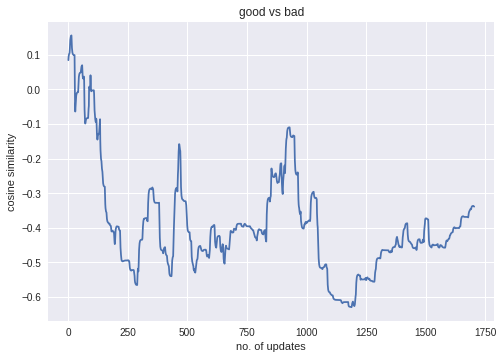

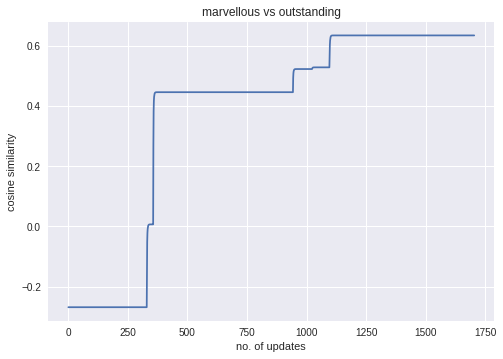

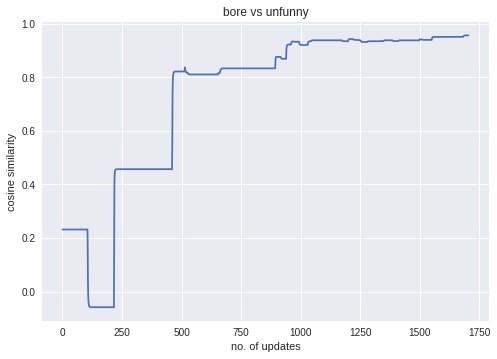

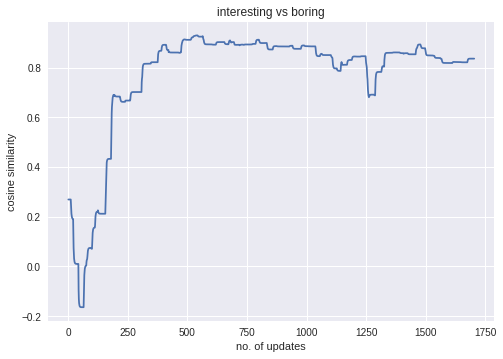

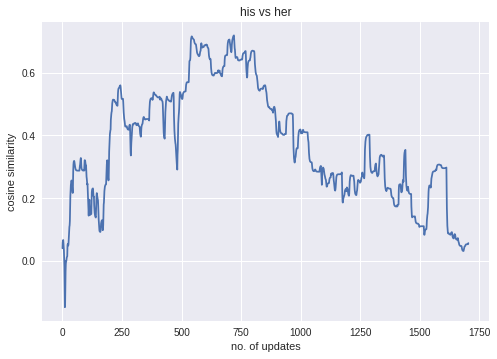

In [14]:
# Tracing code

import matplotlib.pyplot as plt

word_pair_list = zip(["good", "marvellous", "bore", "interesting", "his"],["bad", "outstanding", "unfunny", "boring", "her"])
xlist = range(len(distances_1))
print(distances_1[0])
print(distances_1[1])
z=(np.array(distances_1).reshape([len(distances_1),5]).T)
print(z)
for i in range(5):
  plt.plot(xlist,z[i])
  plt.title(word_pair_list[i][0]+" vs "+word_pair_list[i][1])
  plt.xlabel("no. of updates")
  plt.ylabel("cosine similarity")
  plt.show()
  

In [15]:
c=CNN(len(vocab))
_ = c.train(train_data,test_data,train_targets,test_targets,epochs=1,verbose=False, similar_words=True)

Starting training...
	100 batches finished. Cost : 0.692921392322
	200 batches finished. Cost : 0.694593485892
	300 batches finished. Cost : 0.695016712944
	400 batches finished. Cost : 0.695038392842
	500 batches finished. Cost : 0.693232030153
	600 batches finished. Cost : 0.692248007158
	700 batches finished. Cost : 0.692330631103
	800 batches finished. Cost : 0.687976121604
	900 batches finished. Cost : 0.684569742547
	1000 batches finished. Cost : 0.673150286868
	1100 batches finished. Cost : 0.664230723859
	1200 batches finished. Cost : 0.657689759761
	1300 batches finished. Cost : 0.657262248374
	1400 batches finished. Cost : 0.6582286619
	1500 batches finished. Cost : 0.654427931317
	1600 batches finished. Cost : 0.651180194812
	1700 batches finished. Cost : 0.650336400104
	1800 batches finished. Cost : 0.651202469721
	1900 batches finished. Cost : 0.650202513791
	2000 batches finished. Cost : 0.646725043087
	2100 batches finished. Cost : 0.642722671691
	2200 batches finished. 

[[array([0.08432563], dtype=float32),
  array([-0.26877767], dtype=float32),
  array([0.23150879], dtype=float32),
  array([0.26927105], dtype=float32),
  array([0.04063851], dtype=float32)],
 [array([0.09439808], dtype=float32),
  array([-0.26877767], dtype=float32),
  array([0.23150879], dtype=float32),
  array([0.26927105], dtype=float32),
  array([0.05977025], dtype=float32)],
 [array([0.09935503], dtype=float32),
  array([-0.26877767], dtype=float32),
  array([0.23150879], dtype=float32),
  array([0.26927105], dtype=float32),
  array([0.06347136], dtype=float32)],
 [array([0.10212727], dtype=float32),
  array([-0.26877767], dtype=float32),
  array([0.23150879], dtype=float32),
  array([0.26927105], dtype=float32),
  array([0.06703479], dtype=float32)],
 [array([0.10376639], dtype=float32),
  array([-0.26877767], dtype=float32),
  array([0.23150879], dtype=float32),
  array([0.26927105], dtype=float32),
  array([0.05759144], dtype=float32)],
 [array([0.10476189], dtype=float32),
  

In [18]:
c=CNN(len(vocab))
_ = c.train(train_data,test_data,train_targets,test_targets,epochs=3,verbose=False, get_distance=True, similar_words=True)

Starting training...
Epoch 0: 0.572211204252
	Train accuracy: 0.896353602409
	Test accuracy: 0.758087217808
Epoch 1: 0.291111919872
	Train accuracy: 0.970219254494
	Test accuracy: 0.77355837822
Epoch 2: 0.0996896538425
	Train accuracy: 0.991909980774
	Test accuracy: 0.758087217808
distances between 'good' and 'outsanding' :  0.6691828
distances between 'good' and 'marvelous' :  0.5701299
distances between 'good' and 'awesome' :  0.36126083
distances between 'bad' and 'bore' :  0.7295501
distances between 'bad' and 'tiresome' :  0.71273166
distances between 'bad' and 'disaster' :  0.8272388
distances between 'bad' and 'good' :  -0.69330615
distances between 'bad' and 'outstanding' :  -0.7215193
distances between 'bad' and 'bore' :  0.72955
distances between 'his' and 'good' :  0.37578714
distances between 'his' and 'outstanding' :  0.37075973
distances between 'his' and 'bad' :  -0.44426197
distances between 'his' and 'her' :  0.5736126
distances between 'his' and 'the' :  -0.31673455
d

array([ 0.5736126 , -0.31673455, -0.03738172], dtype=float32)

### Learnings:

List out the observations and conclusions you made from the various experiments. 

**Cosine distance tracking**
  * Cosine distance in this case can be be thought of as a distance between the embedding vector of one word vs the embedding vector of other word. The embedding vector represents the position of the word in a high dimentional space. The values in embedding vector represents the values of dimentions in that space (30 dimentions in our case, becuase embedding vector for a word is of length 30. if it would have been more, then more dimensions)
  * The Cosine similarity vs updates graph shows how the network is learning the similarity and dissimilarity between the words (specifically the words that decide the tone of a sentence).
  * First graph show the progress of cosine similariy between the words "good" and "bad". As expected, it continues to dip (go towards -1) i.e the network is learning representations correctly (loss is going down fine). it continues to stay low til ~800th update. then it starts to rise and then again dip. (I'll be coming on to the explaination for that after  talking about other graphs too).
  * The distance between the other word pairs also continue to progress in right(expected) direction. Although the distance between the words "interesting" and "boring" tends to move in opposite of expected direction (indicaiing these words are similar in meaning, but they are not at all similar!), the general trend is as expected.
  * The reason that the cosine similarity between the "good" and "bad" start to move in wrong direction may be occurence of overfitting. Although this reason cannot be verified by looking at the progress in other graphs. 
  * The cosine similarity between the words "her" and "his" continue to rise and dip as training progress. This behaviour is beacuse of the neutral nature of the words(in context of the tone of sentence). Although they both are accociated to gender, they can show positive cosine similarity(not sure, just a thought).
  
**Similar words**

1.   The words that share same tones tend to be closer to each other(that means the cosine distance between them is near to 1). The cos distance  between 'good' and 'outstanding' is ~0.6 and with 'awesome' is ~0.5, which depicts the similarity between their meanings. Same trend can be observed between the words carrying negative tones (~0.7 between 'bad' and 'disaster').

2.    Words carying opposite tones have cosine distances of relatively larger magnitude. Cosine distance between opposite points in a space is close to -1: Distance between 'bad' and 'outsanding' is ~(-0.6). Similar trend can be seen in other words ( although mild in some cases due to lack of training examples).

3.   Neutral words also displays expected behavior. The cosine distance between two neutral words is around 0 : Distance between 'his' and 'the' :  -0.08498761. The distance increases when we compare it to a word with high magnitude of 'tone'. The cosine distance comes around half the maximum distance as excpected by symmetry : Distance between 'his'(a neutral word) and 'good'(word with positive tone) :  0.5924598
                          
4. As we increase the number of epochs and make it 3 we feel that the model overfits the data. It simply memorizes the data and we get good training accuracy around 99 and there is not much difference in test accuracy, Moreover it decreases as compared to small epochs.


